In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from scipy.integrate import quad

left_blue = "#446B84"
right_red = "#E58073"
centrist_grey = "#E8E8E8"

# Python Workbook: The perils of Political Centrism

This interactive workbook is intended to accompany the paper _The Perils of Political Centrism_, by B&ouml;rgers, Boghosian, Dragovic and Haensch. More details and proofs of theoretical results can be found there.

## I. Introduction

We consider the political spectrum as an axis centered at 0, where negative values correspond to _left-leaning_ ideologies and postive values correspond to _right-leaning_ ideologies.   We make the simplifying assumption that any individual’s political views can be characterized by where they stand on a “left-right axis.” In order to consider all possible positions of a political candidate, we will let -5 and 5 be the most extreme positions, and we will divide the interval from -5 to 5 into `n_positions` many equally sized intervals.

In [ ]:
n_positions = 1000
positions = np.linspace(-5,5, n_positions)

To keep track of values, we will create a dataframe, `df`, in which we will store relevant political positions.

In [ ]:
df = pd.DataFrame(positions, columns = ["position"])
df.head()

,position
0,-5.00000
1,-4.98999
2,-4.97998
3,-4.96997
4,-4.95996


## II. Distribution of Views Among Voters

We will explicitly consider two types of electorates, the _unimodal_ and the _bimodal_.  Rather than dealing with a probably density functions, $f(x)$, explicitly, we're going to use built in functions from [scikit-learn's mixture package](https://scikit-learn.org/stable/modules/mixture.html).

In [ ]:
x = np.random.normal(loc = 0, scale = 1, size = 1000).reshape(-1,1)
unimodal_model = GaussianMixture(n_components=1, random_state=0).fit(x)

In [ ]:
x1 = np.random.normal(loc = -1, scale = .5, size = 1000).reshape(-1,1)
x2 = np.random.normal(loc = 1, scale = .5, size = 1000).reshape(-1,1)
x = np.concatenate([x1,x2])
bimodal_model = GaussianMixture(n_components=2, random_state=0).fit(x)

bimodal_model.means_ = np.array([[-1],[ 1]])
bimodal_model.covariances_ = np.array([[[0.5]],[[0.5]]])
bimodal_model.weights_ = np.array([0.5, 0.5])

This helper function will allow us to compute the density for the unimodal and bimdal models.

In [ ]:
def pdf(x, model):
  """compute probability density function."""
  if type(x) == pd.Series:
    x = x.values.reshape(-1,1)
  elif type(x) == np.ndarray:
    x = x.reshape(-1,1)
  elif type(x) == list:
    x = np.array(x).reshape(-1,1)

  return np.exp(model.score_samples(x))

In [ ]:
df["unimodal_density"] = pdf(df["position"],unimodal_model)
df["bimodal_density"] = pdf(df["position"],bimodal_model)

df.head()

,position,unimodal_density,bimodal_density
0,-5.00000,0.000001,2.343983e-15
1,-4.98999,0.000001,2.761325e-15
2,-4.97998,0.000001,3.251638e-15
3,-4.96997,0.000002,3.827442e-15
4,-4.95996,0.000002,4.503360e-15


Let's plot this data so we can see what the electorate distribution on our political spectrum looks like. 

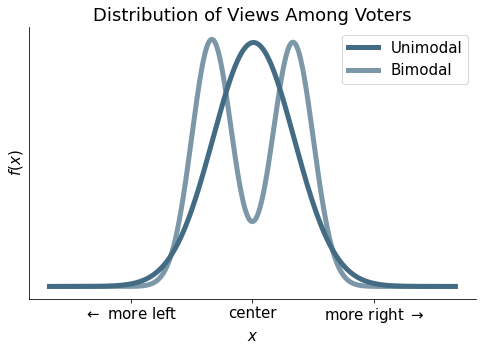

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(df["position"], df["unimodal_density"], linewidth = 5, label = "Unimodal", 
        color = left_blue, alpha = 1)
ax.plot(df["position"], df["bimodal_density"], linewidth = 5, label = "Bimodal",
        color = left_blue, alpha = .7)

ax.set_xticks([-3,0,3])
ax.set_xticklabels([r"$\leftarrow$ more left", "center", r"more right $\rightarrow$"], fontsize = 15)
ax.set_xlabel(r"$x$", fontsize = 15)
ax.set_yticks([])
ax.set_ylabel(r"$f(x)$", fontsize = 15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(fontsize = 15)
plt.title("Distribution of Views Among Voters", fontsize = 18)
plt.show()

## III. Who Wins the Election?

We consider two candidates called $L$ and $R$.
Their positions on the x-axis are $\ell$ and $r$, with $\ell < r$. We assume that a voter whose
position is closer to $\ell$ than to $r$ will vote for $L$, and a voter whose position is closer to $r$
than to $\ell$ will vote for $R$. We also assume, for now, that everybody votes. The fractions
of voters who vote for L and R, respectively, are then

$$
S_L = \int_{-\infty}^{\frac{\ell+r}{2}} f(x)\,\,dx \text{ and }S_R = \int_{\frac{\ell+r}{2}}^{\infty} f(x) \,\,dx.
$$

We will compute these integrals using [SciPy's intergrate.quad package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html).


In [ ]:
def pdf_integrand(x, model):
    return pdf([x], model)

def get_left_share(left_position, right_position, model):
  """Compute left candidate vote share."""
  lower = -np.inf
  upper = (left_position + right_position)/2
  return quad(pdf_integrand, lower, upper, args=(model))[0]

def get_right_share(left_position, right_position, model):
  """Compute right candidate vote share."""
  lower = (left_position + right_position)/2
  upper = np.inf
  return quad(pdf_integrand, lower, upper, args=(model))[0]

In [ ]:
ell = -1
r = 3

left_share = get_left_share(left_position = ell, right_position = r, model = unimodal_model)
right_share = get_right_share(left_position = ell, right_position = r, model = unimodal_model)

We can plot these vote shares to see what the outcome of the election looks like.  We'll just plot the bimodel model here, but you can try adapting this code to plot election results for other underlying distributions too.

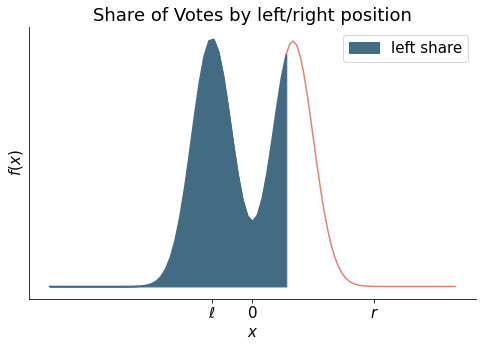

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))

left_position = np.linspace(-5,left_share)
left_density = pdf(left_position, model = bimodal_model)

right_position = np.linspace(left_share, 5)
right_density = pdf(right_position, model = bimodal_model)

ax.plot(left_position, left_density, color = left_blue)
ax.plot(right_position, right_density, color = right_red)

if left_share > right_share:
  ax.fill_between(left_position, left_density, label = "left share", color = left_blue)
if right_share > left_share:
  ax.fill_between(right_position, right_density, label = "right share", color = right_red)

ax.set_xticks([ell,0,r])
ax.set_xticklabels([r"$\ell$", 0, r"$r$"], fontsize = 15)
ax.set_xlabel(r"$x$", fontsize = 15)
ax.set_yticks([])
ax.set_ylabel(r"$f(x)$", fontsize = 15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(fontsize = 15)
plt.title("Share of Votes by left/right position", fontsize = 18)
plt.show()


## IV. Coalescence of Candidate Views

For a fixed $r$, we can easily see that it's always in the best interested of candidate $L$ to move closer to candidate $R$.  To see an easy example of this, we can compute the vote share as a function of $\ell$ for a fixed $r$.

In [ ]:
r = 2
ell_positions = np.linspace(-5,r)
left_shares = []
for ell in ell_positions:
  left_share = get_left_share(left_position = ell, right_position = r, model = bimodal_model)
  left_shares.append(left_share)

Now let's plot our results.

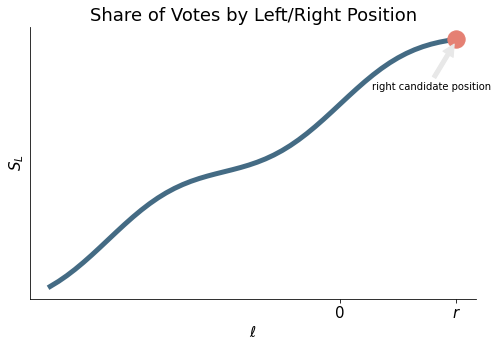

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(ell_positions, left_shares, linewidth = 5, color = left_blue, zorder = 0)
ax.scatter(r,left_shares[-1], s= 300, color = right_red, zorder = 1)

#Add arrow annotation
ax.annotate('right candidate position', xy=(r - .01, left_shares[-1] - .01),  xycoords='data',
            xytext=(.90, .80), textcoords='axes fraction',
            arrowprops=dict(facecolor= centrist_grey, edgecolor = centrist_grey, shrink=0.05),
            horizontalalignment='center', verticalalignment='top',
            )

ax.set_xticks([0,r])
ax.set_xticklabels([0,r"$r$"], fontsize = 15)
ax.set_xlabel(r"$\ell$", fontsize = 15)
ax.set_yticks([])
ax.set_ylabel(r"$S_L$", fontsize = 15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("Share of Votes by Left/Right Position", fontsize = 18)
plt.show()

If both candidates are opportunistic, they might follow a system of differential equations, such as 

$$
\frac{d\ell}{dt} = \alpha\frac{dS_L}{d\ell}(\ell,r) = \frac{\alpha}{2}\cdot f\left(\frac{\ell+ r}{2}\right)
$$

and

$$
\frac{dr}{dt} = \alpha\frac{dS_R}{dr}(\ell,r) = -\frac{\beta}{2}\cdot f\left(\frac{\ell+ r}{2}\right)
$$

where $\alpha$ and $\beta$ are positive constants.  We'll define another useful helper function here to determine the intersection of lines.

In [ ]:
def get_intersection(a1, a2, b1, b2):
  """ Compute intersection of two lines.
          y = (a2 - a1)x + a1
          y = (b2 - b1)x + b1
  """
  x = (a1 - b1) /  ((b2 - b1) - (a2 - a1))
  y = ((a2 - a1) * x) + a1
  return x,y

def coalescing_candidates(left_position, right_position, model, alpha = 1, beta = .5):
  """Simulate colaescing of candidate positions."""
  ell_positions = []
  r_positions = []
  y = None
  while left_position < right_position:
    delta = pdf(x = [(left_position + right_position)/2], model = bimodal_model)[0]
    left_position += (alpha/2)*delta
    right_position += (-beta/2)*delta
    if left_position < right_position:
      ell_positions.append(left_position)
      r_positions.append(right_position) 
    else:
      x, y = get_intersection(ell_positions[-1], left_position, r_positions[-1], right_position)
      ell_positions.append(y)
      r_positions.append(y)

  if y:
    for i in range(10):
        ell_positions.append(y)
        r_positions.append(y)

  return ell_positions, r_positions

In [ ]:
ell_positions, r_positions = coalescing_candidates(left_position = -1, right_position = 2, model = bimodal_model, alpha = 1, beta = .5)

Now we'll plot our results.

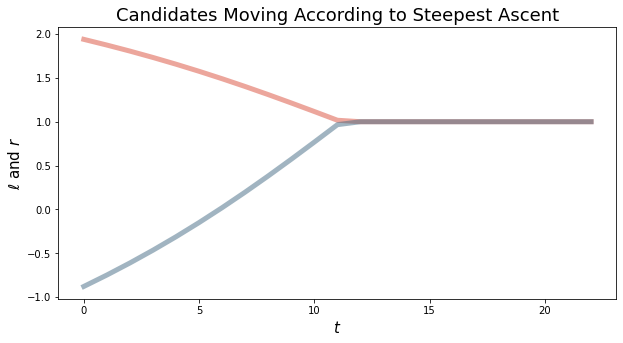

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(range(len(r_positions)), r_positions, color = right_red, linewidth = 5, alpha = .7)
ax.plot(range(len(ell_positions)), ell_positions, color = left_blue, linewidth = 5, alpha = .5)

ax.set_xlabel(r"$t$", fontsize = 15)
ax.set_ylabel(r"$\ell$ and $r$", fontsize = 15)
ax.set_title("Candidates Moving According to Steepest Ascent", fontsize = 18)
plt.show()

## V. Voter Disillusionment Counteracts Coalescence

So far in our model, we've assumed that the voter prefers whichever candidate is closer to them. Now we're going to add an additional wrinkle, namely, if the preferred candidate is beyond some threshold of the voters position, then the voter will stay home.  In other words, for a left-leaning voter at position $x$, if $\mid \ell - x\mid$ is large, then the voter will stay home. Now we will model the share of votes obtained by the left candidate as 

$$
S_L = S_L(\ell, r) = \int_{-\infty}^{\frac{\ell+r}{2}}f(x) \cdot g(\mid \ell - x\mid )\,\,dx
$$
where $g:[0:\infty)\rightarrow (0,1]$ is a decreasing function with $g(0) = 1$.  In our examples below we will take $g$ to be a particularly nice function, 
$$
g_\gamma(z) = e^{-z/\gamma}
$$
where $\gamma >0$ is a measure of voter tolerance.  Larger $\gamma$ means larger tolerance towards candidate shifts in ideology.  First we will define a few helper functions.

In [ ]:
def g_func(z, gamma):
  return np.exp(-z/gamma)

def integrand(x, left_position, right_position, gamma, model):
    x = np.array([x])
    f = pdf(x, model = model)
    g = g_func(np.abs(left_position - x), gamma)
    return f * g

def left_integral(left_position, right_position, gamma, model):
  """ Compute numerical integral for left candidate share."""
  lower = -np.inf
  upper = (left_position + right_position)/2
  I = quad(integrand, lower, upper, args=(left_position, right_position, gamma, model))
  return I[0]

def right_integral(left_position, right_position, gamma, model):
  """ Compute numerical integral for right candidate share."""
  lower = (left_position + right_position)/2
  upper = np.inf
  I = quad(integrand, lower, upper, args=(left_position, right_position, gamma, model))
  return I[0]

In [ ]:
def left_share_with_g(left_position, right_position, gamma, model):
  """Compute left candidate vote share."""
  if left_position > right_position: 
    raise ValueError("The left candidate must be to the left of the right candidate.")
  return left_integral(left_position, right_position, gamma, model)

def right_share_with_g(left_position, right_position, gamma, model):
  """Compute left candidate vote share."""
  if left_position > right_position: 
    raise ValueError("The left candidate must be to the left of the right candidate.")
  return right_integral(left_position, right_position, gamma, model)


Now we can compute the share of left votes as a function of left voter position.  We'll fix $r = 1$ and let $\gamma = -\infty, 5, 4, 3, 2, 1, 0.5$.

In [ ]:
r = 1
ell_positions = np.linspace(-5,r)
share_dict = {}
position_dict = {}

gamma = [np.inf, 5, 4, 3, 2, 1, 0.5]
for g in gamma:
  left_shares = []
  left_positions = []
  for ell in ell_positions:
    left_share = left_share_with_g(left_position = ell, right_position = r, gamma = g, model = bimodal_model)
    left_shares.append(left_share)
  share_dict[g] = left_shares

Now let's plot our results.

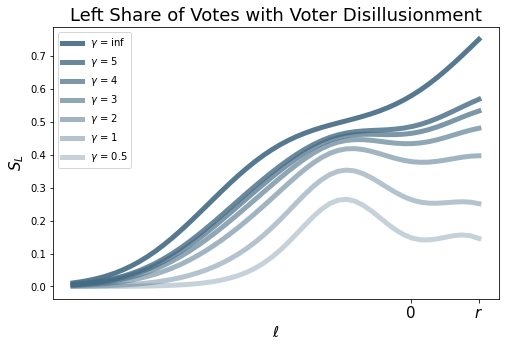

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))

for g in gamma:
  ax.plot(ell_positions, share_dict[g], label = r"$\gamma$ = "+f"{g}", linewidth = 5, 
          color = left_blue, alpha = 1-((gamma.index(g) + 1)/10))

ax.set_xticks([0,r])
ax.set_xticklabels([0,r"$r$"], fontsize = 15)
ax.set_xlabel(r"$\ell$", fontsize = 15)
ax.set_ylabel(r"$S_L$", fontsize = 15)
ax.set_title("Left Share of Votes with Voter Disillusionment", fontsize = 18)

plt.legend()
plt.show()

Next, we will look at how the share of votes changes as a function of candidate position, with the introduction of the intolerant voter function.  We'll define the following two functions to help us compute numerical derivatives.  We'll be approximating derivatives using the symmetric difference quotient.

In [ ]:
def left_derivative(x,right_position, gamma, model, h = 0.001):
  """Compute numerical derivative for left candidate change."""
  forward_sum = left_share_with_g(x + h, right_position, gamma, model)
  backward_sum = left_share_with_g(x - h, right_position, gamma, model)
  return (forward_sum - backward_sum) / (2*h)

def right_derivative(x,left_position, gamma, model, h = 0.001):
  """Compute numerical derivative for right candidate change."""
  forward_sum = right_share_with_g(left_position, x + h, gamma, model)
  backward_sum = right_share_with_g(left_position, x - h, gamma, model)
  return (forward_sum - backward_sum) / (2*h)

Now we can simulate the change in left vote share as a function of $\ell$, that is, 
$$
\frac{\partial S_L}{\partial \ell} = \frac{\partial }{\partial \ell} \left[\int_{-\infty}^{\frac{\ell + r}{2}} f(x) g_\gamma\left(\mid\ell - x\mid\right)\,\,dx\right].
$$  

We'll fix $r=1$ and loop through $\gamma = 6,4,2,1,0.5$

In [ ]:
r = 1

ell_positions = np.linspace(-5,r -.001)
gamma = [6, 4, 2, 1, .5]
share_dict = {}
for g in gamma:
  left_derivatives = []
  for ell in ell_positions:
    D = left_derivative(ell,right_position = r, gamma = g, model = bimodal_model)
    left_derivatives.append(D)

  share_dict[g] = left_derivatives

Now let's plot our results.

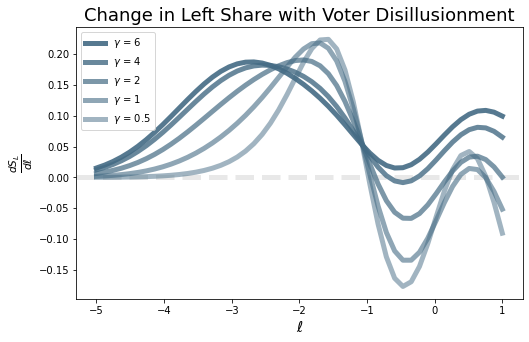

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))

for g in gamma:
  ax.plot(ell_positions,share_dict[g], label = r"$\gamma$ = "+f"{g}", linewidth = 5,
          color = left_blue, alpha = 1-((gamma.index(g) + 1)/10))

ax.axhline(0, linestyle = "--", linewidth = 5, color = centrist_grey, zorder = 0)
ax.set_xlabel(r"$\ell$", fontsize = 15)
ax.set_ylabel(r"$\frac{dS_L}{d\ell}$", fontsize = 15)
ax.set_title("Change in Left Share with Voter Disillusionment", fontsize = 18)

plt.legend()
plt.show()

Finally, we want to see what candidate positions look like over time in the presence of intolerant voters by simulating the change in $\ell$ and $r$ as a function of $t$.  Once again we $r$ and $\ell$ are functions of time that follow the equations 
$$
\frac{d\ell}{dt} = \alpha \frac{\partial S_L}{\partial \ell}(\ell, r)
$$
and
$$
\frac{dr}{dt} = \beta \frac{\partial S_R}{\partial r}(\ell, r)
$$ 
where $\alpha$ and $\beta$ are positive integers.

In [ ]:
def coalescing_candidates_with_g(left_position, right_position, model, gamma, alpha, beta):
  """Simulate colaescing of candidate positions with voter tolerance."""
  ell_positions = []
  r_positions = []
  y = None
  for i in range(200):
    left_delta = left_derivative(left_position, right_position, gamma, model)
    right_delta = right_derivative(right_position, left_position, gamma, model)
    left_position += alpha*left_delta
    right_position += beta*right_delta
    if left_position < right_position:
      ell_positions.append(left_position)
      r_positions.append(right_position) 
    else:
      x, y = get_intersection(ell_positions[-1], left_position, r_positions[-1], right_position)
      ell_positions.append(y)
      r_positions.append(y)
      break

  if y:
    for j in range(i,200):
      ell_positions.append(y)
      r_positions.append(y)
      
  return ell_positions, r_positions

Now we'll see how the candidate positions change as a function of time.  We'll start with $\ell = -1$, $r=1.5$, $\alpha = 1$, $\beta = 0.1$ and we'll look at a range of $\gamma$ values.

In [ ]:
gamma = np.linspace(3.3, 3.5, 25)
final_ell_positions = []
ell_dict = {}
r_dict = {}
for i in range(len(gamma)):
  ell_positions, r_positions = coalescing_candidates_with_g(left_position = -1, 
                                                    right_position = 1.5, 
                                                    model = bimodal_model, 
                                                    gamma = gamma[i], 
                                                    alpha = 1, 
                                                    beta = 0.1)
  ell_dict[gamma[i]] = ell_positions
  r_dict[gamma[i]] = r_positions
  final_ell_positions.append(ell_positions[-1])


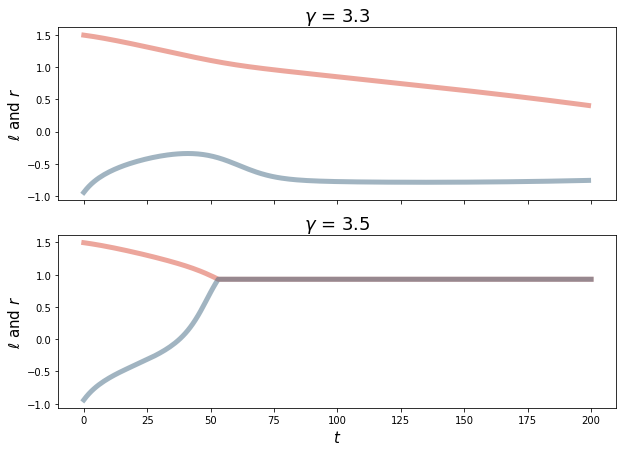

In [ ]:
plot_gamma = [3.3, 3.5]
fig, ax = plt.subplots(len(plot_gamma), 1, figsize = (10,7), sharex = True)

for i in range(len(plot_gamma)):
  g = plot_gamma[i]
  ell_positions = ell_dict[g]
  r_positions = r_dict[g]
  ax[i].plot(range(len(r_positions)), r_positions, color = right_red, linewidth = 5, alpha = .7)
  ax[i].plot(range(len(ell_positions)), ell_positions, color = left_blue, linewidth = 5, alpha = .5)
  ax[i].set_ylabel(r"$\ell$ and $r$", fontsize = 15)
  ax[i].set_title(r"$\gamma$ = "+f"{g}", fontsize = 18)

ax[1].set_xlabel(r"$t$", fontsize = 15)
plt.show()

Finally, we can make a plot of candidate $L$'s final position as a function of $\gamma$ to show the discontinuity in optimal position.  If we suppose a starting point of $\ell = -1$ and $r = 1.5$, with $\alpha = 1$ and $\beta = 0.1$, we obtain the following plot.

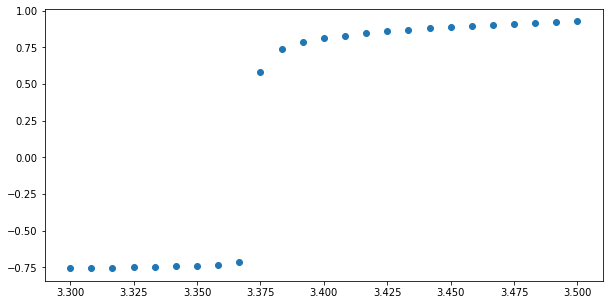

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

ax.scatter(gamma, final_ell_positions)

plt.show()